### Team Info

#### Project Title: Reddit User Investment Advice Performance


#### Group Name: Group 24

#### Names and PIDS: 
Ariq Rashid (ariqr), 
Minh Tran (minhtran1379), 
Sihua Kang(sihuak), 
Bailey McKelway (baileymckelway), 
Lingyu Zhou (lingyuz)


### Project Introduction

#### Initial Description: 
Reddit is a social media site with many forums. In recent years it has become a popular spot for amateur investors to share investment advice. Some of the more popular subreddits for investing are /r/wallstreetbets and /r/investing. Through Reddits API we have access to user comments dating back multiple years. We want to scrape individual user's comments that give investment advice.

#### Research Questions: 
Can we determine if a user gives good investment advice based on which stock they support and when they give that adivce. Comparing it to the stock's price at that date and the current stock price.

Can we apply Sharpe's Ratio to a users investment adivce over time to score the quality of their advice.

How accurate and reliable is investment advice shared on Reddit compared to advice from professional financial advisors?


#### Description of potential source data: 
https://www.reddit.com/r/wallstreetbets/
https://www.reddit.com/r/investing/
https://finance.yahoo.com
https://www.reddit.com/dev/api/


# Part 2

## The Plan

Our plan involved utilizing web scraping and sentiment analysis to track mentions of specific stocks on finance subreddits. The subreddits we will be searching through are: r/Investing, r/Wallstreetbets, r/Stocks, and r/Daytrading. Firstly, we selected a group of stocks to monitor and then scrape the subreddits for any mentions of their tickers. The stocks we have chosen to track are: Apple, Google, Meta, Tesla, AMC, and Exxon Mobil. Following that, we stored user information and their posts which contain mentions of the selected tickers. Next, the posts underwent sentiment analysis to determine if the sentiment was positive or negative. Finally, the users' sentiment analysis was compared with a graph of the stock to assess the accuracy of their recommendation. 

## Step 1: Scrapping

To scrape the subbreddits for mentions of our selected stock tickers, we used the Python Reddit API Wrapper, also known as PRAW. There is another API called Pushshift, that we considered using. They are both free but there are notable differences between the two, but we decided to go with PRAW due to its ease of use and that we'd only be reading from Reddit, and not making our own posts..

To be able to use PRAW, we had to `pip install` praw in our command line to have access to its libraries.Once that is done, we imported the libraries.

In [9]:
import praw
from praw.models import MoreComments
from datetime import datetime
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import ast
import numpy as np
import statistics
import json
import re

Next, we had to create our own reddit app. We went to https://www.reddit.com/prefs/apps to create our own app. We named our app *FinanceScraper*. After creating the app, we were provided the necessary keys in order to create our own Reddit instance that is neccessary to use the API.

In [37]:
reddit = praw.Reddit(
        client_id = "YcedLYlL5lKNipYeF2NDqw",
        client_secret = "ftAn2nfvdg4i01X75UsTxiRgxHfcCQ",
        user_agent = "Finance Scraper for CMDA/CS 3654 Project",)

Now that we had proper access to the API, we could begin scraping usernames and posts. We first had to make sure that the users we were choosing were not automoderators or bots, so we created a function called `is_bot()` to check.

In [38]:
'''
Paramter: user - a redditor object

Return: True if user is not an automod or a bot
'''
def is_bot(user):
    return user.name.lower() == 'automoderator' or user.name.lower() == "bot"

Then, we needed to be able to search for any mention of a ticker through a specified subreddit in a given time frame. We created the `search_for_tickers()` function. Any post that had the ticker in the title, we stored the user in a dictionary as 'key', and the value(s) would be their posts that had the ticker. It incorporates the `is_bot()` function before adding adding a user to the dictionary.

In [39]:
'''
Parameters: ticker - ticker to search for
            subreddit - subreddit to search through
            user_dict - dictionary of user with posts mentioning ticker
            time - how far back to search (day, week, month, year)
'''
def search_for_ticker(ticker, subreddit, user_dict, time_frame):
    
    search_results = subreddit.search(f'title:{ticker}', time_filter=time_frame)
    
    #Loops through each post that matches the search result
    for post in search_results:
        if post.selftext != '':
        #Checks if author is a bot, then adds to dictionary
            if is_bot(post.author) == False:
                
            #Checks if author is already in dictionary
                if (post.author.name not in user_dict):
                        user_dict[post.author.name] = []
                    
            #Checks if post.id is already in dictionary    
                if post.id not in user_dict[post.author.name]:
                        user_dict[post.author.name].append(post.id)    


Since the tickers and mentions can slightly vary but mean the same thing($AAPL and Apple) and we needed to search through multiple subreddits in a given time frame. We created a function that takes a list of tickers and a list of subreddits and incoroporates the `search_for_ticker()` function within it. We called this function `search_from_subs()` that returns a dictionary of the users and their posts mentioning the tickers: `{'user': ['post1_id', 'post2_id']}` .

In [40]:
'''
Parameters: tickers - list of tickers to search for
            subreddit - list of subreddits to search through
            time_frame - how far back to search (day, week, month, year)
            
Returns: user_dict - a dictionary of users who mentioned tickers in list of subs, their post_ids as values
'''
def search_from_subs(tickers, subreddits, time_frame):
    
    user_dict = {}
    
    for sub in subreddits:
        for ticker in tickers:
            
            search_for_ticker(ticker, sub, user_dict, time_frame)
    
    return user_dict

With these functions, all we needed was the subreddits and tickers. We created instances for each subreddit and put them in a list called `subreddits`.

In [41]:
#Create instances for each subreddit
wsb = reddit.subreddit("wallstreetbets")
invest = reddit.subreddit("investing")
stocks = reddit.subreddit("stocks")
daytrade = reddit.subreddit("daytrading")

# crypto should only be used if checking for cryptocurrencies
# crypto = reddit.subreddit("cryptocurrency")

#Put subreddits in list
subreddits =  [wsb, invest, stocks, daytrade]

Then we create a list of tickers and names for each stock we wanted to track and search for. For now, we will just track Apple and name the list `apple_tickers`.

In [42]:
#List of apple tickers to search for
apple_tickers = ['AAPL', 'Apple', 'apple']

We have everything we need to scrape and create the dictionary. We searched through the past year for mentions of the tickers in the four subreddits. We will name the dictionary `apple_dict`.

In [43]:
apple_dict= search_from_subs(apple_tickers, subreddits, "year")

## Step 2: Sentiment Analysis

Now that we had the users and their posts, we could conduct sentiment analysis. To do this, we first needed a list of positive and negative words to mark for. These lists were provided by Professor North in class.

In [ ]:
positive_words = set(open('positive.txt').read().split())
negative_words = set(open('negative.txt').read().split())

Then we had to create a function that searches for these words, and counts their frequency. Then  we woud see if the post was mostly positive or negative. If it's positive, we would consider that as the user "recommending" or "buying" the stock. If it was negative, we would consider them "selling".

In [ ]:
def Analysis_tendency(text):

    words_bag = text.replace(',', '').replace('!', '').replace(',', '').replace('.', '').replace('?', '').replace(':', '').lower().split()
    pos = len([word for word in words_bag if word in positive_words])
    neg = len([word for word in words_bag if word in negative_words])
    if neg > pos:
        return 0 #if the sentence is in negtive tendency we return 0
    
    return  1 #if the sentence is in postive tendency we return 1

A problem we came across while doing this is that we needed to run the functions everyday to get the data, and that calling upon the API to do it would take some time. Therefore, we decided that we would save the data in a csv file, so that we would not have to rely upon the API at this point. We went ahead and created a dataframe withe user_ids, post_ids, the titles, the date it was posted, and its tendency according to our function.

In [ ]:
df = pandas.DataFrame.from_dict(apple_dict, orient='index')
df.columns = ['post_id']
df['Title'] = df['post_id'].apply(lambda x: reddit.submission(id=x).title)
df['Time'] = df['post_id'].apply(lambda x: datetime.fromtimestamp(reddit.submission(id=x).created_utc))
df['Tendency'] = df['post_id'].apply(lambda x: Analysis_tendency(reddit.submission(id=x).selftext))
df['Username'] = df.index

In [ ]:
df.to_csv('Fixed_data.csv', index=False)

Now, we can access and call upon the data whenver without relying upon the API and running the previous cells.

In [12]:
c = pandas.read_csv('Fixed_data.csv')
c

,post_id,Title,Time,Tendency,Username
0,10s71tx,"Thoughts on AMZN, AAPL, GOOGL at market open t...",2023-02-02 20:20:20,1,IT_lurks_below
1,z7ytgm,I just bought elongated puts AAPL,2022-11-29 11:34:17,1,Endoskeleton1
2,ztoj34,The stock market should NOT bottom until $AAPL...,2022-12-23 13:05:19,1,Degenereth
3,10mdnjo,SQQQ Feb1 before AAPL sets the world on fire?,2023-01-27 00:57:31,1,Lurking_In_A_Cape
4,10ejmg7,"Race to dominate AI tech: Comparing MSFT, GOOG...",2023-01-17 13:35:01,1,OliveInvestor
...,...,...,...,...,...
173,zqlzo4,$AAPL (Apple) breakdown trade today for +2.8 R,2022-12-20 06:26:15,1,supertexter
174,vtscmo,Day trading AAPL with 100k,2022-07-07 16:34:37,1,garruslol
175,uac3rp,"In reality, do SPY stocks (eg AAPL) or futures...",2022-04-23 14:50:14,1,dizzydes
176,102nc19,Apple Gap Fill?,2023-01-03 18:36:17,0,Scalper_91


## Part 3: Visualiztions

Now that we have data and have done analysis on it, we attempted to visualize it. We selected a few users and put their recommendation on a graph. To attempt to answer one of our questions, we designed a function for calculating "Sharpe's Ratio". Sharpe ratio divides a portfolio's excess returns by a measure of its volatility to assess risk-adjusted performance. At this point of the project, we were only handling a single post for one user, so we were not able to impelement it at this stage.

In [16]:
def calc_sharpe_ratio(df):
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Get the purchase time
        purchase_time = pandas.to_datetime(row['Time'])
        
        # Get the ticker symbol
        ticker_symbol = 'AAPL'
        
        # Get the closest stock data to the purchase time
        stock_data = yf.download(ticker_symbol, start=purchase_time.date())
        stock_data = stock_data.iloc[np.argmin(np.abs(stock_data.index.values - purchase_time.to_numpy()))]

        
        # Convert the purchase price to float
        purchase_price = float(row['Tendency'])
        
        # Calculate the daily return
        close_price = stock_data['Close']
        daily_return = close_price.pct_change().iloc[-1]
        
        # Calculate the standard deviation of daily returns
        daily_returns = close_price.pct_change().dropna()
        std_daily_returns = np.std(daily_returns)
        
        # Calculate the sharpe ratio
        sharpe_ratio = (daily_return - 0.005) / std_daily_returns
        
        # Update the dataframe with the sharpe ratio
        df.at[index, 'Sharpe Ratio'] = sharpe_ratio
    
    return df

Next, we created a function that takes the data and plots users against the stock graph. We imported the `yfinance` library to help us. For reasons that will be explained towards the end, we selected only a few users and did not display their username on the graph.

In [19]:


def plot_stock_and_comments(df):
    # Get the Apple Inc. stock data from Yahoo Finance for the past year
    stock_data = yf.download("AAPL", period="2y", interval = "1d")
    
    # Create a plot for the stock data
    fig, ax = plt.subplots()
    ax.plot(stock_data['Close'], label="AAPL")
    
    # Loop through each comment in the dataframe
    for i, row in df.iterrows():
        # Convert the time string in the comment to a datetime object
        comment_time = datetime.strptime(row['Time'], "%Y-%m-%d %H:%M:%S")
        # Get the stock data for the comment date
        price = stock_data.loc[str(comment_time.date())]
        stock_price = stock_data.loc[str(comment_time.date())]['Close']
        
        # Add a marker on the plot for the comment date and tendency
        if row['Tendency'] == 'positive':
            ax.plot(comment_time, stock_price, 'go')
        elif row['Tendency'] == 'negative':
            ax.plot(comment_time, stock_price, 'ro')
        else:
            ax.plot(comment_time, stock_price, 'yo')
        
        # Add the comment title as a label to the marker
        ax.annotate(str(i), (comment_time, stock_price))
    
    # Set the plot title and axis labels
    ax.set_title("Apple Inc. Stock Data and Comments")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price")
    plt.plot()
    # Save the plot as a file
    # fig.savefig("apple_comments.png")



## Part 4: Findings and Review

For this second part, we successfully scraped data from Reddit using the API, were able to conduct basic sentiment analysis on Reddit posts, and were able to graph the results of our analysis to a graph. We made major progress during this part, but had a few setbacks and lessons that we will have to take into account to refine it more.

One of the problems we came across, is that not all users have appropriate usernames. We were not able to showcase a lot of the users do this, and opted to select a few users and just use their index in the dataframe. Therefore we will have to account for that in the next part. 

The second problem is that we need to develop a more thorough sentiment analysis algorithm. We encountered some posts that didn't have enough words to analyze, or were just links. We will have to filter and account for these posts in the future.

The third problem we came across is that there were some errors with our graphing function. It succesfully graphs the stock data and the points. It has to do with how we pass on and process the data structure in this function.

The fourth problem that we will elaborate on next, is that we were unable to apply Sharpe's ratio as we wanted to. The Reddit API would rate-limit our requests a lot, so it would take a while to get all the comments and posts. Therefore, we chose just use one post per user, to get foundations of our research correct.

Now, let's take a look at the questions we had in Part 1.

**"Can we determine if a user gives good investment advice based on which stock they support and when they give that adivce. Comparing it to the stock's price at that date and the current stock price."**

We were able to deciper user advice from the language of their post, and were able to get the graph data as well. We were unable to vizualize the relationship between these, and will continue to work on it.

**"Can we apply Sharpe's Ratio to a users investment adivce over time to score the quality of their advice"**

We were not able to apply Sharpe's ratio at this stage due to limiting one post per user.


**"How accurate and reliable is investment advice shared on Reddit compared to advice from professional financial advisors?"**

This part is yet to be determined after we do a holistic review of our data when use multiple stock tickers instead of one.

## Report Part 2 Conclusion

In conclusion, we were able to build the framework and understand what is necessary in order to complete a thorough analysis on our topic. We encountered many logical and technical errors along the way that will need to be addressed in this upcoming stage. We were not able to answer all of our questions just yet, but look forward to doing so soon. We stay committed to our original goal and hope to be able turn this data into an interesting report for readers.

## Part 2 Contribution

Web Scraping and Report - Ariq Rashid(ariqr) and Minh Tran(minhtran1379)

Sentiment Analysis - Sihua Kang(sihuak) and Lingyu Zhou (lingyuz)

Sharpe Ration and Visualiztion -  Bailey McKelway (baileymckelway)

# Part 3: Second Pass through and Conclusions

We now have all the tools needed to effectively compile and analyze the data in order to answer the questions we had. First, we had to refine our scrapping process.

Previously, we were just simply searching for one user mentioning one stock. In order to accurately tell which user gave the best "advice" they need to have a history of talking about multiple stocks. Therefore, we had to find users who talked about more than one stock. Modification of our previous functions was needed, and was changed so that it checks if a post meets our criteria of having text.


In [ ]:
def is_valid_post(post):
    """
    Returns True if the post has 4 or more words, is not an image, is not only a link, and is not made by a bot or Automoderator.
    """
    if post.is_self:  # Check if the post is a text post
        # Split the post text into words and check if the length of the resulting list is >= 4
        if len(post.selftext.split()) >= 4:
            return True
    elif post.url.endswith('.jpg') or post.url.endswith('.png'):  # Check if the post is an image
        return False
    elif post.url == post.permalink:  # Check if the post is only a link to itself
        return False
    else:
        user = post.author
        if user and (user.name.lower() == 'automoderator' or 'bot' in user.name.lower()):
            return False
        else:
            return True

Our search_for_ticker function was renamed and modified to search_for_ticker_posts because now we want to be able to store multiple posts to a single user.


In [ ]:
'''
Parameters: ticker - ticker to search for
            subreddit - subreddit to search through
            user_dict - dictionary of user with posts mentioning ticker
            time - how far back to search (day, week, month, year)
'''
def search_for_ticker_posts(ticker, subreddit, user_dict, time_frame):
    
    search_results = subreddit.search(f'title:{ticker}', time_filter=time_frame)
    
    #Loops through each post that matches the search result
    for post in search_results:
        
        if is_valid_post(post):
            author = post.author.name
            post_id = post.id
                
            #Checks if author is already in dictionary
            if (author not in user_dict):
                user_dict[author] = []
                    
            if post_id not in user_dict[author]:
                user_dict[author].append(post_id)


Instead of searching and analyzing one stock, multiple was necessary. We chose 8 of some of the most popular stocks mentioned on reddit, as mentioned on. https://www.finder.com/reddit-stocks-to-buy

In [ ]:
tickers = ['AAPL', 'TSLA', 'AMD', 'AMZN', 'MSFT', 'NVDA', 'NFLX', 'META']

tsla_tickers = ['TSLA', 'Tesla', 'tesla', 'TESLA']
appl_tickers = ['AAPL', 'APPLE', 'Apple','apple']
amd_tickers = ['AMD', 'amd']
msft_tickers = ['MSFT', 'MICROSOFT', 'Microsoft']
amzn_tickers = ['AMZN', 'Amazon', 'amazon', 'AMAZON']
nvda_tickers = ['NVDA','nvda', 'NVDIA', 'Nvdia']
nflx_tickers = ['NFLX', 'nflx', 'NETFLIX', 'Netflix']
meta_tickers = ['META', 'Meta', 'meta']

We searched through the same 5 subreddits as before, and needed to created 8 dictionaries now. This process take a little bit of time, since it needs to scrape through a year's worth of posts at least 8 times per subreddit. Therefore, we wanted to collect the data only once and save it, so that we do not have to keep calling upon the API everytime. Also, as each day passes, we may lose and gain new posts in each dictionary, since it will not be searching the exact same time frame. Then, a list of all the dictionaries are made.


In [ ]:
tsla_dict= search_from_subs(tsla_tickers, subreddits, "year")
appl_dict= search_from_subs(appl_tickers, subreddits, "year")
msft_dict= search_from_subs(msft_tickers, subreddits, "year")
amzn_dict= search_from_subs(amzn_tickers, subreddits, "year")
nvda_dict= search_from_subs(nvda_tickers, subreddits, "year")
nflx_dict= search_from_subs(nflx_tickers, subreddits, "year")
meta_dict= search_from_subs(meta_tickers, subreddits, "year")

dict_list = [appl_dict, tsla_dict, amd_dict, amzn_dict, msft_dict, nvda_dict, nflx_dict, meta_dict]

Next, we wanted only keep users who have posted about 2 or more of thes stocks. A function called create_user_post_df, It takes a list of dictionaries and essentially finds the common keys amongst them, then puts their values into individual columns.


In [ ]:
def create_user_post_df(dict_list):
    # Create a set of all unique usernames
    all_users = set()
    for dictionary in dict_list:
        all_users.update(dictionary.keys())

    # Create a dictionary with each username as the key and an empty dictionary as the value
    user_post_dict = {user: {} for user in all_users}

    # Iterate through each dictionary in the list
    for i, dictionary in enumerate(dict_list):
        # Iterate through each user in the dictionary
        for user in dictionary:
            # Iterate through each post_id for the user
            for post_id in dictionary[user]:
                # Add the dictionary name as a column and the post_id as a value in the corresponding row
                user_post_dict[user].setdefault(i, []).append(post_id)
                
    # Fill any missing user keys with an empty dictionary
    for user in all_users:
        if user not in user_post_dict:
            user_post_dict[user] = {}
                
    # Convert the user_post_dict to a DataFrame
    df = pd.DataFrame.from_dict(user_post_dict, orient='index')
    # Rename the columns with the corresponding dictionary names
    df.columns = [f"dict_{i}" for i in range(len(dict_list))]

    return df

We created the dataframe using the new function, then we needed to rename the columns to their appropriate stock tickers. Finally, we had to save it to a csv so we can have easy access to the data.


In [ ]:
dataframe = create_user_post_df(dict_list)

dataframe = dataframe.rename(columns={'dict_0': '$AAPL', 'dict_1': '$AMZN', 'dict_2': '$META', 'dict_3' : '$NFLX',
                                'dict_4': '$TSLA', 'dict_5': '$GOOGL', 'dict_6':'$NVDA', 'dict_7':'$AMD'})

dataframe_two = dataframe.dropna(thresh=2)
dataframe_two.to_csv('user-and-posts-data.csv', index = True)

We now had a proper dataset to analyze.


In [7]:
df = pd.read_csv('user-and-posts-data.csv', index_col=0)

df.head()

,$AAPL,$AMZN,$META,$NFLX,$TSLA,$GOOGL,$NVDA,$AMD
AP9384629344432,['y9xr61'],['ugx8u8'],['udcu5q'],NaN,NaN,NaN,NaN,NaN
Not_FinancialAdvice,['use3jf'],NaN,NaN,NaN,NaN,['zg8c32'],NaN,NaN
WickedSensitiveCrew,"['12qwfjn', 'zvzi00', '10jckme', 'zbtscx', 'yd...","['zvzi00', 'zbq9l8', 'uvdh4x']",['zvzi00'],NaN,['12ekzkx'],"['1154egt', 'zrouhg', 'zvzi00', 'v8hln1']",NaN,NaN
stock_122,['zx9zfc'],NaN,NaN,NaN,NaN,NaN,['zrkv2i'],['zrkv2i']
AwesomeMathUse,['ue4ooi'],NaN,['10ran75'],NaN,NaN,NaN,NaN,NaN


Since we would be analyzing multiple posts per user, we wanted to keep track of which stock they were talking about in that post. We decided to make a similar dataframe but instead of post_ids, it would be the data of each post such as its title, date posted, and its sentiment.

In [ ]:
def Make_Dictionary(post, ticker):
    
    red = reddit.submission(id=post)
    text = red.selftext
    date = datetime.fromtimestamp(red.created_utc)
    tittle = red.title
    subreddit = red.subreddit
    contant_tendency = Analysis_tendency(text)
    tittle_tendency = Analysis_tendency(tittle)
    total = tittle + text
    total_tendency = Analysis_tendency(total)
    Dict = dict([('tittle', tittle),('text', text),('date', date),('ticker', ticker),('subreddit', subreddit),
                 ('text_sentiment', contant_tendency),('tittle_sentiment', tittle_tendency),('sentiment', total_tendency)])
    
    return Dict

Then we needed to read through each column and and apply it to each it post, as seen below.

In [ ]:
def Switch_list(lis, ticker):
    if lis == 0:
        return 0
    new_list = []
    l = ast.literal_eval(lis)
    for post in l:
        dic = Make_Dictionary(post, ticker)
        new_list.append(dic)
        
    return new_list

In [ ]:
df_two = df.copy()

In [ ]:
df_two['$AAPL'] = df['$AAPL'].apply(lambda x: Switch_list(x, '$AAPL'))
df_two['$AMZN'] =  df['$AMZN'].apply(lambda x: Switch_list(x, '$AMZN'))
df_two['$META'] =  df['$META'].apply(lambda x: Switch_list(x, '$META'))
df_two['$NFLX'] =  df['$NFLX'].apply(lambda x: Switch_list(x, '$NFLX'))
df_two['$TSLA'] =  df['$TSLA'].apply(lambda x: Switch_list(x, '$TSLA'))
df_two['$GOOGL'] =  df['$GOOGL'].apply(lambda x: Switch_list(x, '$GOOGL'))
df_two['$NVDA'] =  df['$NVDA'].apply(lambda x: Switch_list(x, '$NVDA'))
df_two['$AMD'] =  df['$AMD'].apply(lambda x: Switch_list(x, '$AMD'))

We saved this dataframe to a csv, because this was a another lenghty process that used the API. After this point, we will not be needing the API anymore.

In [ ]:
df_two.to_csv('update_data.csv', index=True)

In [8]:
posts = pandas.read_csv('update_data.csv', index_col=0)

posts

,$AAPL,$AMZN,$META,$NFLX,$TSLA,$GOOGL,$NVDA,$AMD
AP9384629344432,"[{'tittle': ""There's more to index funds and s...",[{'tittle': 'WSJ: Amazon Workers Reject Union ...,[{'tittle': 'Shares of Facebook parent Meta ju...,0,0,0,0,0
Not_FinancialAdvice,[{'tittle': 'Michael Burry vs Warren Buffett o...,0,0,0,0,[{'tittle': 'FTC sues to block Microsoft’s acq...,0,0
WickedSensitiveCrew,[{'tittle': 'Goldman Sachs is watching for ‘ca...,[{'tittle': 'Meta and Alphabet lose dominance ...,[{'tittle': 'Meta and Alphabet lose dominance ...,0,[{'tittle': 'Tesla cuts U.S. prices for fifth ...,[{'tittle': 'Microsoft limits Bing A.I. chats ...,0,0
stock_122,[{'tittle': '$V VS $MA VS $AAPL.... are $V and...,0,0,0,0,0,[{'tittle': 'Which one would you buy the dip? ...,[{'tittle': 'Which one would you buy the dip? ...
AwesomeMathUse,[{'tittle': 'Apple Reports Second Quarter Resu...,0,[{'tittle': 'Meta reports 22Q4 and FY22 financ...,0,0,0,0,0
...,...,...,...,...,...,...,...,...
RememberYo,0,0,0,0,0,0,[{'tittle': 'Should I sell my NVDA shares are ...,[{'tittle': 'I can confirm AMD has touched us ...
Virus4762,0,0,0,0,0,0,"[{'tittle': 'How does AMD compare to NVDA?', '...","[{'tittle': 'How does AMD compare to NVDA?', '..."
dumbledoreRothIRA,0,0,0,0,0,0,"[{'tittle': '$25.7K YOLO on AMD NVDA, my gf is...","[{'tittle': '$25.7K YOLO on AMD NVDA, my gf is..."
Thurmulx,0,0,0,0,0,0,"[{'tittle': 'NVDA vs AMD? Which to purchase?',...","[{'tittle': 'NVDA vs AMD? Which to purchase?',..."


Now that we had data on each user, and their posts, we can calculate Sharpe's Ratio.The Sharpe ratio is typically used to compare the performance of different investments, portfolios, or strategies. A higher Sharpe ratio indicates better risk-adjusted performance, as it means that the investment is generating more return per unit of risk taken. We developed our own function in order calculate the ratio for each user.

In [ ]:
current_date_time = datetime.now()
def calculate_sharpe_ratio(person):
    portfolio_value = 0
    portfolio_return = 0
    portfolio_volatility = 0
    count = 0
    for ticker, data in person.items():
        if data != 0:
            ticker = ticker[1:]
            stock_data = yf.download(ticker, start=data[0]['date'], end=current_date_time)
            stock_return = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0]
            stock_volatility = stock_data['Close'].pct_change().std() * (252 ** 0.5)
            stock_weight = 1 / len(person)
            if data[0]['sentiment'] == 0:
                stock_return *= -1
            portfolio_return += stock_return * stock_weight
            portfolio_volatility += stock_volatility ** 2 * stock_weight ** 2
    portfolio_volatility = portfolio_volatility ** 0.5
    excess_return = portfolio_return - risk_free_rate
    if portfolio_volatility == 0:
        return 0
    else:
        sharpe_ratio = excess_return / portfolio_volatility
        return sharpe_ratio

With this function, we created a new column in our dataframe. The Sharpe's ratio for each user.

In [ ]:
posts['Sharpe Ratio'] = df.apply(calculate_sharpe_ratio, axis=1)
posts = df.sort_values(by='Sharpe Ratio', ascending=False)

Once again, we saved the csv so that we do not have to run the functions everytime.

In [ ]:
temp = posts.copy()
temp.to_csv('after_sharpes_ratio.csv', index=True)

In [10]:
sh_data = pd.read_csv('after_sharpes_ratio.csv', index_col = 0)
sh_data

,$AAPL,$AMZN,$META,$NFLX,$TSLA,$GOOGL,$NVDA,$AMD,Sharpe Ratio
BlazingJava,0,"[{'tittle': 'Amazon Monthly Moving Average', '...","[{'tittle': 'META Bloodbath', 'text': ""Meta ju...",0,0,0,0,0,2.660843
Catgang_Lock,0,[{'tittle': 'Should I invest in Meta or Amazon...,[{'tittle': 'Should I invest in Meta or Amazon...,0,0,0,0,0,2.102418
k_ristovski,0,0,[{'tittle': 'Meta stock analysis and valuation...,0,[{'tittle': 'Tesla stock collapse - All you ne...,0,0,0,2.035905
Ok_Remove3123,"[{'tittle': 'Apple stock price below 120?', 't...",0,0,0,0,0,"[{'tittle': 'NVDA vs AMD? Which is better', 't...","[{'tittle': 'NVDA vs AMD? Which is better', 't...",1.613097
WickedSensitiveCrew,[{'tittle': 'Goldman Sachs is watching for ‘ca...,[{'tittle': 'Meta and Alphabet lose dominance ...,[{'tittle': 'Meta and Alphabet lose dominance ...,0,[{'tittle': 'Tesla cuts U.S. prices for fifth ...,[{'tittle': 'Microsoft limits Bing A.I. chats ...,0,0,1.587465
...,...,...,...,...,...,...,...,...,...
Brothanogood,0,0,0,[{'tittle': 'Netflix lays off 300 more employe...,[{'tittle': 'Elon Musk sold around $4 billion ...,0,0,0,-1.688451
Lilipad42,[{'tittle': 'Why do you think Apple took down ...,0,[{'tittle': 'Why do you think Apple took down ...,0,0,0,0,0,-1.718861
bwang29,[{'tittle': 'Is AAPL sucking the blood out of ...,0,[{'tittle': 'Is AAPL sucking the blood out of ...,[{'tittle': 'Is AAPL sucking the blood out of ...,0,[{'tittle': 'Is AAPL sucking the blood out of ...,0,[{'tittle': 'Is AAPL sucking the blood out of ...,-2.263767
predictany007,[{'tittle': 'Apple (AAPL) is reportedly cuttin...,[{'tittle': 'Amazon lost half its value this y...,[{'tittle': 'Facebook parent company Meta is n...,[{'tittle': 'Netflix misses subscriber estimat...,"[{'tittle': 'Tesla cuts prices for Model 3, Mo...",[{'tittle': 'Alphabet (GOOGL) and Microsoft (M...,0,[{'tittle': 'AMD revenue warning signals deep ...,-2.380643


With this data, first we wanted to see how well our users did overall against the market. We calculated the the average sharpe's ratio of our dataset.

In [12]:
sharpes_ratio_list = sh_data['Sharpe Ratio'].to_list()
mean = statistics.mean(sharpes_ratio_list)

print('The mean is: ', mean)

The mean is:  0.07381639919895469


Below is the histogram of the Sharpe's Ratio for the users we analyzed.

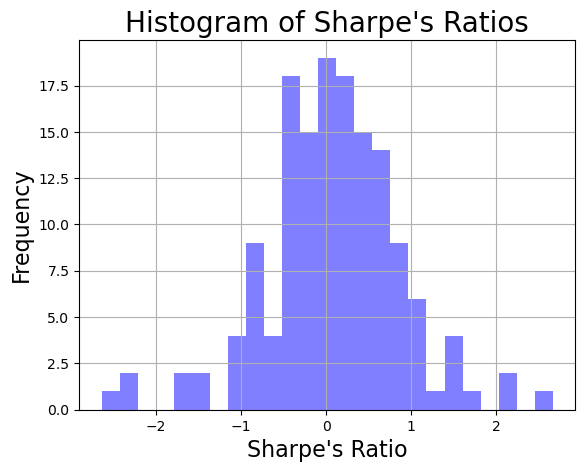

In [15]:
plt.hist(sharpes_ratio_list, bins=25, color='blue', alpha=0.5)


plt.title("Histogram of Sharpe's Ratios", fontsize=20)
plt.xlabel("Sharpe's Ratio", fontsize=16)
plt.ylabel("Frequency", fontsize=16)


plt.grid(True)


plt.show()

This is what we expected. The market's Sharpe's ratio is 0, and we can see that the users make bell-curve like figure around it.

Now, we want to visually see the the users with the best and worst Sharpe's Ratio. We developed a function that would plot the time of the user's post on the graph of the stock. A green dot indicates that they "bought" the stock and red indicates that they "sold".

In [ ]:
def plot_stock_and_comments(df, user):
    tickers = df.columns
    tickers = tickers.tolist()
    tickers = [ticker.replace('$', '') for ticker in tickers]
    tickers = [s for s in tickers if 'Sharpe Ratio' not in s]
    for tick in tickers:
        stock_data = yf.download(tick, period="1y", interval = "1d")
        fig, ax = plt.subplots()
        ax.plot(stock_data['Close'], label=tick)
    
        user_data = df.loc[user]
        comments = user_data.loc["$" + tick]
        if comments == 0:
            continue;
        for i in comments:
                comment_time = datetime.strptime(str(i['date']), "%Y-%m-%d %H:%M:%S")
    
                if comment_time.date() in stock_data.index:
                    stock_price = stock_data.loc[str(comment_time.date())]['Close']
                else:
                    closest_date_idx = np.abs(stock_data.index - comment_time).argmin()
                    stock_price = stock_data.iloc[closest_date_idx]['Close']


                if i['sentiment'] == 1:
                    ax.plot(comment_time, stock_price, 'go')
                elif i['sentiment'] == 0:
                    ax.plot(comment_time, stock_price, 'ro')
                else:
                    ax.plot(comment_time, stock_price, 'yo')
        
        # Set the plot title and axis labels
        ax.set_title(user_data.name + ": " + tick + " Stock Data and Comments")
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        plt.plot()
        fig.savefig(user_data.name + ": " + tick + ".png")

Below, are some of the graphs  of the stock these users talked about and how well it did in the market. It was generated by the function we developed above.

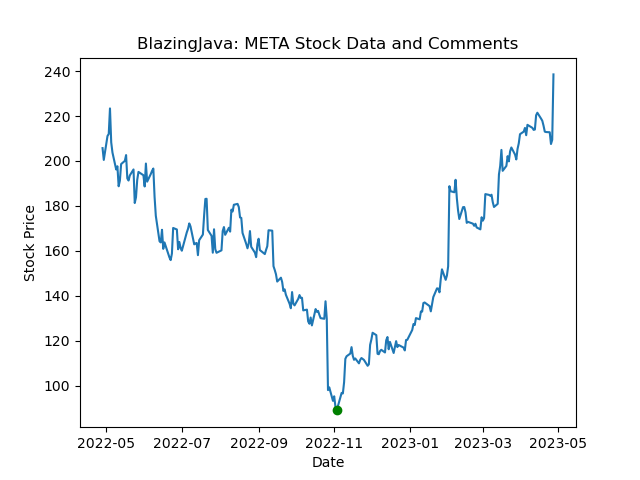

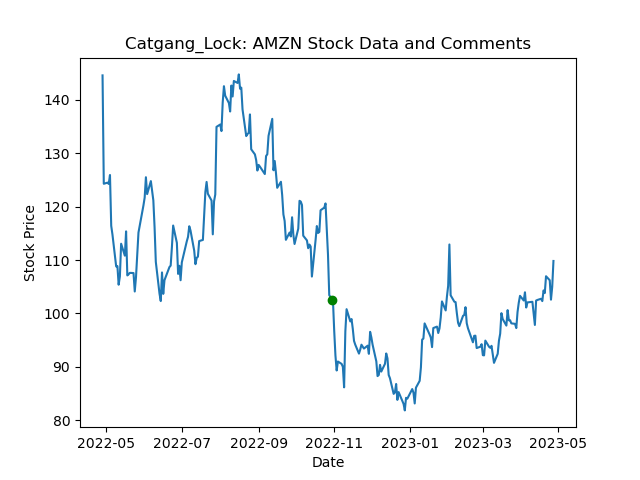

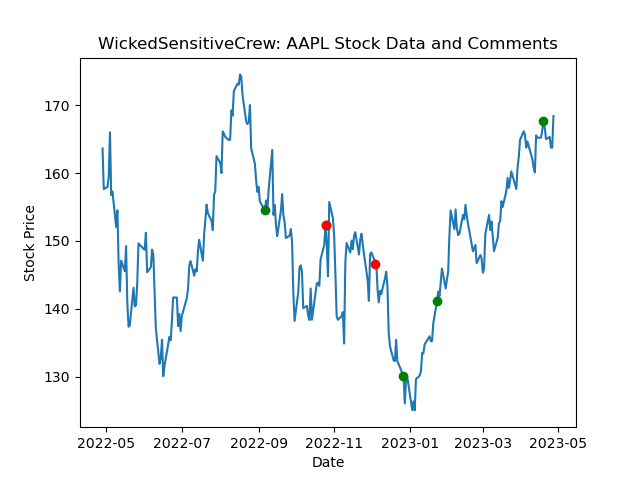

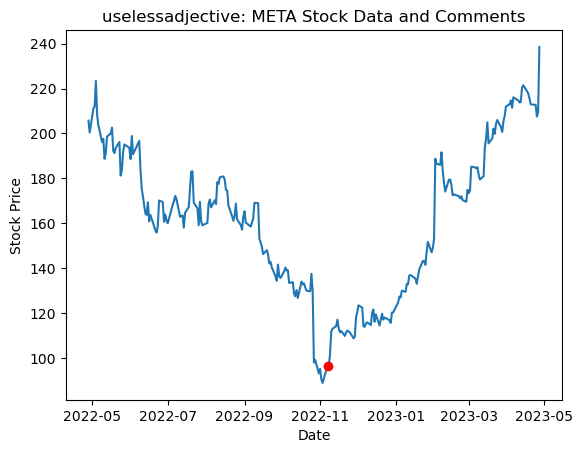

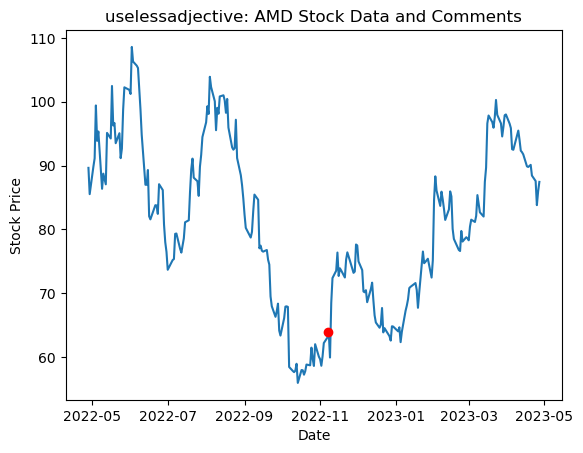

Now that we have completed our more refined pass-through and analysis, we have to look back and answer our initial questions.

## Can we determine if a user gives good investment advice based on which stock they support and when they give that adivce. Comparing it to the stock's price at that date and the current stock price.

Yes, we were able to conduct sentiment analysis on reddit posts related to a particular stock or company using natural language processing techniques. To do this, we developed our own criteria for determining whether a post was positive, negative, or neutral based on the sentiment expressed in the text.

After analyzing the sentiment of the posts, we were able to graph the sentiment scores alongside the stock's price graph to explore any potential relationships or correlations between the two. This allowed us to gain insights into how public sentiment towards a company or stock might impact its market performance.


## Can we apply Sharpe's Ratio to a users investment adivce over time to score the quality of their advice.


Once we had conducted sentiment analysis on social media posts related to a particular stock or company, we then looked for users with multiple posts about that topic. Using the sentiment scores for their first post, we were able to calculate their Sharpe ratio, which is a measure of risk-adjusted return.

To calculate the Sharpe ratio, we treated the sentiment score as an indicator of whether the user had made a purchase or a sale. If their first post had a positive sentiment, we treated it as a purchase, while a negative sentiment was treated as a sale. By using this approach, we were able to calculate the Sharpe ratio for each user and visualize it on a graph.

## How accurate and reliable is investment advice shared on Reddit compared to advice from professional financial advisors?


The accuracy of financial investment advice on Reddit can vary depending on various factors, including the specific subreddit, the quality of the analysis and advice, and the expertise of the users providing the advice.

In our analysis, we found that the Sharpe ratio average for our Reddit investment advice was slightly higher than the market's average. This could be due to several factors, including the fact that the market's average Sharpe ratio is typically zero, and our Reddit investment advice had an average Sharpe ratio of 0.75.

However, it's important to note that our analysis only looked at a small portion of the Reddit community and a relatively short range of time (one year). This limited sample size and time frame may not be enough to accurately represent the broader Reddit community's investment advice and performance.



## End of the Part 3 Report